In this notebook, I tried to build a model that can generate poetry. Next, I will describe the problems I encountered, how I tried to deal with them, and what could be improved to achieve better results than mine.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import random
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud

np.random.seed(42)
tf.random.set_seed(42)

path_to_df='/kaggle/input/poetry-foundation-poems/PoetryFoundationData.csv'

2025-10-06 09:52:18.400069: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759744338.748355      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759744338.840655      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df=pd.read_csv(path_to_df)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13854 entries, 0 to 13853
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  13854 non-null  int64 
 1   Title       13854 non-null  object
 2   Poem        13854 non-null  object
 3   Poet        13854 non-null  object
 4   Tags        12899 non-null  object
dtypes: int64(1), object(4)
memory usage: 541.3+ KB


In [4]:
print(df.Poem.iloc[1])

In [5]:
df.Poet.value_counts()

Poet
William Shakespeare      85
Alfred, Lord Tennyson    73
Emily Dickinson          51
William Wordsworth       51
Rae Armantrout           49
                         ..
Lynn Powell               1
Jeramy Dodds              1
Larry Bradley             1
Maudelle Driskell         1
Judith Kroll              1
Name: count, Length: 3128, dtype: int64

This dataset contains 13,854 poems by 3,128 poets, which makes it overloaded with various styles and vocabularies. I tried several approaches to find a common style so that the model could produce at least somewhat coherent output. Since I’m limited by the free usage time on Kaggle, in the end I use only the approach I consider the most successful, but I will show a few others.

# Methods


In [6]:
def words_visual(df):
    data = " ".join(df["clean_Poem"].astype(str))
    data = data.replace("<LINEBREAK>", " ")  # to see words w/o linebreaks

    wordcloud = WordCloud(max_font_size=50,
                          max_words=100,
                          background_color="black").generate(data)

    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [7]:
# method to replace line breaks with a corresponding tag.
def preprocess_poem(text):
    text = text.replace("\r\r\n", " <LINEBREAK> ")
    return text

In [8]:
# method that outputs statistics on the number of unique words in a sample.
def max_word_check(df, name):
  MAX_VOCAB = 100
  tokenizer = Tokenizer(num_words=MAX_VOCAB, filters='', lower=True, oov_token="<UNK>")
  tokenizer.fit_on_texts(df["clean_Poem"])
  max_words = len(tokenizer.word_index)
  sequences = tokenizer.texts_to_sequences(df['clean_Poem'])
  total_words = sum(len(seq) for seq in sequences)

  print(f"Words max count in {name}: {max_words} in {len(df)} poems. {total_words} аll words ({max_words/total_words:.2f} unique/total words) ")


In [9]:
df["clean_Poem"] = df["Poem"].apply(preprocess_poem)
max_word_check(df, 'df')

Words max count in df: 273432 in 13854 poems. 3814179 аll words (0.07 unique/total words) 


# Theme-based aggregation

In this dataset, most poems have tags. By combining the tags into "themes," we can obtain a common set of words characteristic of a theme and general expressions.

In [10]:
tags_dummies = df["Tags"].str.get_dummies(sep=",")

In [11]:
tags_dummies.sum()

 & Streams    568
 Heavens      265
 Lesbian      122
 Planets      265
 Queer        122
             ... 
Weather       306
Weddings       39
Winter        268
Yom Kippur      8
Youth         156
Length: 129, dtype: int64

In [12]:
weather_columns = ['Winter', 'Weather', 'Summer','Fall']
religons_columns = ['Religion', 'Other Religions', 'Judaism','Islam', 'God & the Divine', 'Christianity']
love_columns = [ ' Queer', ' Lesbian', 'Gay','Break-ups & Vexed Love', 'First Love', 'Men & Women', 'Separation & Divorce', 'Marriage & Companionship']
life_columns = [ 'Birth & Birthdays','Funerals', 'Get Well & Recovery', 'Infancy','Coming of Age', 'Death',  'Living', 'Time & Brevity']
holiday_columns = ['Cinco de Mayo','Hanukkah','Ramadan', "St. Patrick's Day",  'Rosh Hashanah','Independence Day', 'Labor Day',  'Eating & Drinking', 'Anniversary', "Valentine's Day"]

In [13]:
df_expanded = pd.concat([df, tags_dummies], axis=1)

In [14]:
def get_df_w_col(selected_theme):
  df = pd.DataFrame(df_expanded.loc[df_expanded[selected_theme].any(axis=1), 'Poem'])
  return df

df_weather = get_df_w_col(weather_columns)
df_religons= get_df_w_col(religons_columns)
df_love = get_df_w_col(love_columns)
df_life = get_df_w_col(life_columns)
df_holiday = get_df_w_col(holiday_columns)

In [15]:
df_weather["clean_Poem"] = df_weather["Poem"].apply(preprocess_poem)
df_religons["clean_Poem"] = df_religons["Poem"].apply(preprocess_poem)
df_love["clean_Poem"] = df_love["Poem"].apply(preprocess_poem)
df_life["clean_Poem"] = df_life["Poem"].apply(preprocess_poem)
df_holiday["clean_Poem"] = df_holiday["Poem"].apply(preprocess_poem)

In [16]:
max_word_check(df_weather,'df_weather')
max_word_check(df_religons,'df_religons')
max_word_check(df_love,'df_love')
max_word_check(df_life,'df_life')
max_word_check(df_holiday,'df_holiday')

Words max count in df_weather: 34388 in 768 poems. 207065 аll words (0.17 unique/total words) 
Words max count in df_religons: 79750 in 1495 poems. 627066 аll words (0.13 unique/total words) 
Words max count in df_love: 57049 in 1384 poems. 418189 аll words (0.14 unique/total words) 
Words max count in df_life: 157755 in 6306 poems. 1853833 аll words (0.09 unique/total words) 
Words max count in df_holiday: 29444 in 585 poems. 155018 аll words (0.19 unique/total words) 


We have some basic statistics on word diversity; we can also generate a "word cloud" to visually see how well the themes are represented when training on these datasets.

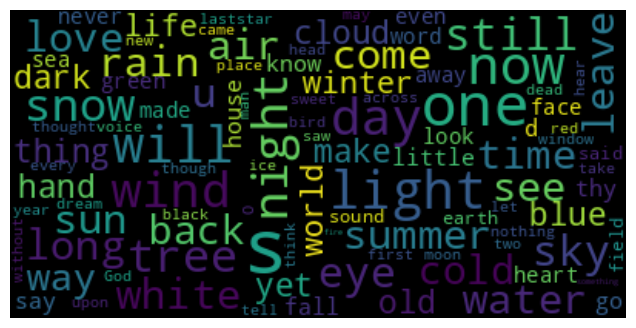

In [17]:
words_visual(df_weather)

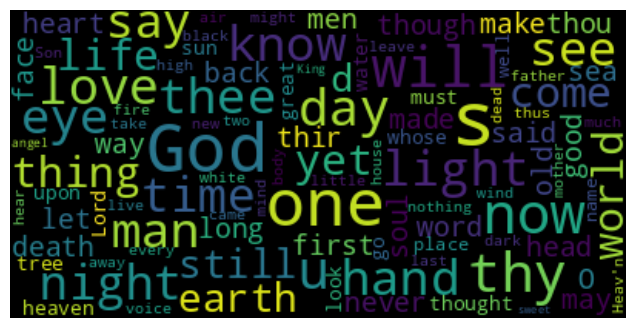

In [18]:
words_visual(df_religons)

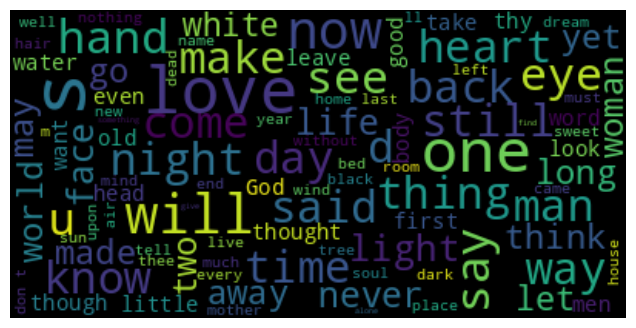

In [19]:
words_visual(df_love)

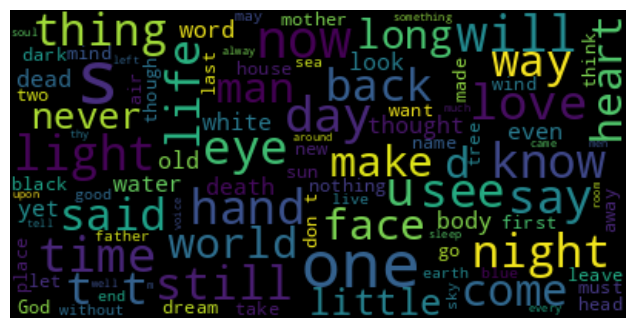

In [20]:
words_visual(df_life)

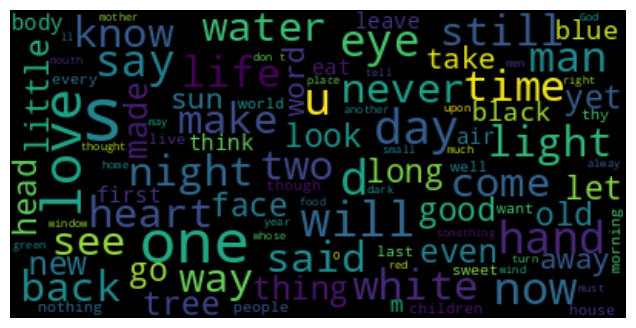

In [21]:
words_visual(df_holiday)

# Random subset

Let's just take a random set of poems — what could possibly go wrong…

In [22]:
df_small = df.sample(1000, random_state=42)
df_small["clean_Poem"] = df_small["Poem"].apply(preprocess_poem)
max_word_check(df_small,'df_small')

Words max count in df_small: 42949 in 1000 poems. 262224 аll words (0.16 unique/total words) 


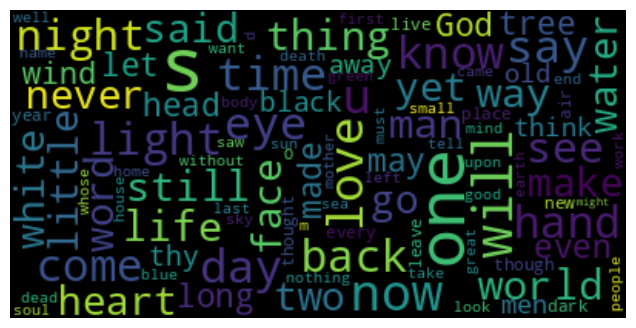

In [23]:
words_visual(df_small)

# Poets aggregation

We have a column indicating the authors of the poems. I picked the 3 most frequently occurring ones.

In [24]:
df_Shakespeare  = pd.DataFrame(df.loc[(df.Poet=='William Shakespeare'), 'Poem'])
df_Alfred = pd.DataFrame(df.loc[(df.Poet=='Alfred, Lord Tennyson'), 'Poem'])
df_Dickinson  = pd.DataFrame(df.loc[(df.Poet=='Emily Dickinson'), 'Poem'])

df_Shakespeare["clean_Poem"] = df_Shakespeare["Poem"].apply(preprocess_poem)
df_Alfred["clean_Poem"] = df_Alfred["Poem"].apply(preprocess_poem)
df_Dickinson["clean_Poem"] = df_Dickinson["Poem"].apply(preprocess_poem)

In [25]:
max_word_check(df_Shakespeare,'df_Shakespeare')
max_word_check(df_Alfred,'df_Alfred')
max_word_check(df_Dickinson,'df_Dickinson')

Words max count in df_Shakespeare: 6155 in 85 poems. 21360 аll words (0.29 unique/total words) 
Words max count in df_Alfred: 7436 in 73 poems. 31737 аll words (0.23 unique/total words) 
Words max count in df_Dickinson: 1543 in 51 poems. 4811 аll words (0.32 unique/total words) 


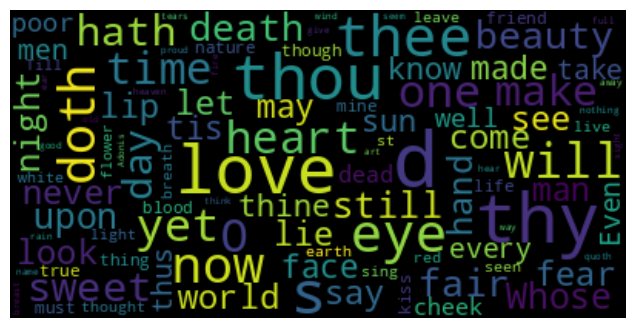

In [26]:
words_visual(df_Shakespeare)

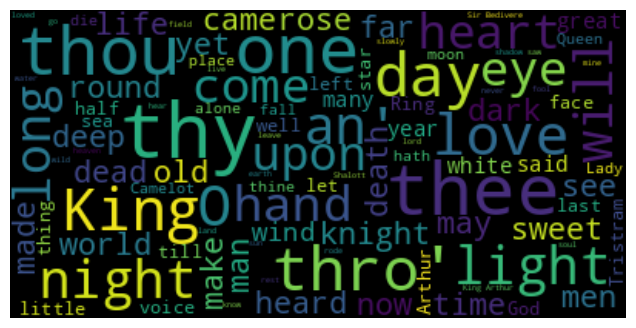

In [27]:
words_visual(df_Alfred)

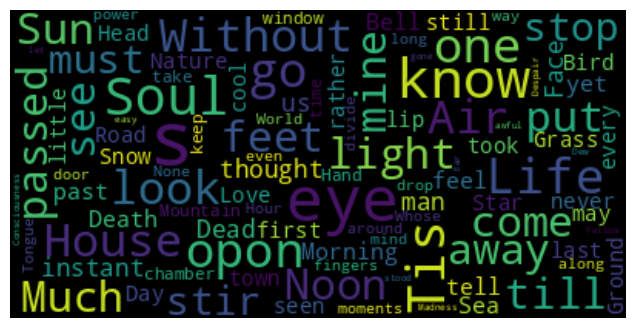

In [28]:
words_visual(df_Dickinson)

I also tried combining several poets, since there were too few poems from each individually for proper training, but the generation results didn’t really satisfy me…

In [29]:
df_poets = pd.DataFrame(df.loc[(df.Poet=='William Shakespeare') | (df.Poet=='Alfred, Lord Tennyson') | (df.Poet=='Emily Dickinson'), 'Poem'])

In [30]:
df_poets["clean_Poem"] = df_poets["Poem"].apply(preprocess_poem)
max_word_check(df_poets,'df_poets')

Words max count in df_poets: 12459 in 209 poems. 57908 аll words (0.22 unique/total words) 


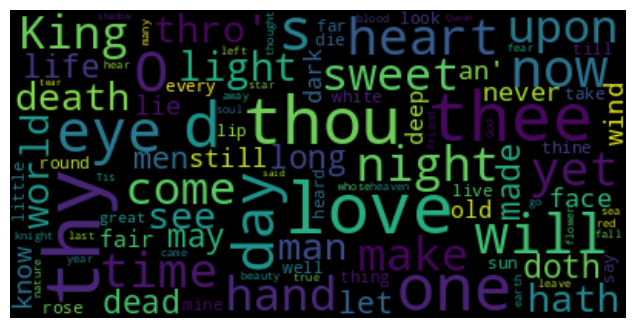

In [31]:
words_visual(df_poets)

# Model

I chose to generate poems specifically based on the df_weather theme, because the resulting poems turn out more coherent than when training on other datasets. Also, this is a small dataset, so each training step takes less time. Naturally, the generation isn’t perfect, and fully training the model isn’t possible due to the time limits on free GPU access. However, it’s enough to get a general idea of the results.

In [32]:
# IMPORTANT PARAMS
MAX_VOCAB = 34000
MAX_SEQ_LEN = 60
BATCH_SIZE = 512
selected_df = df_weather

tokenizer = Tokenizer(num_words=MAX_VOCAB, filters='', lower=True, oov_token="<UNK>")
tokenizer.fit_on_texts(selected_df["clean_Poem"])

sequences = []
for line in selected_df["clean_Poem"]:
    encoded = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        ngram_seq = encoded[:i+1]
        sequences.append(ngram_seq)

sequences = pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding="pre")

X, y = sequences[:, :-1], sequences[:, -1]

dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = dataset.shuffle(MAX_VOCAB).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1759744387.010651      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759744387.011290      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


The model is designed to be compact, with a large batch size. Everything is set up to make each training step faster due to time limitations.

In [33]:
model = keras.Sequential([
    layers.Embedding(MAX_VOCAB, 100, input_length=MAX_SEQ_LEN-1),
    layers.Bidirectional(layers.GRU(32, return_sequences=True)),
    layers.Dropout(0.2),
    layers.GRU(16),
    layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dense(MAX_VOCAB, activation="softmax")
])

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer='adam',
    metrics=["accuracy"])

print(model.summary())

history = model.fit(dataset, epochs=250, verbose=2)

model.save("poem_model.h5")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/250


I0000 00:00:1759744394.798669      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


403/403 - 21s - 52ms/step - accuracy: 0.0940 - loss: 7.8590
Epoch 2/250
403/403 - 14s - 35ms/step - accuracy: 0.0990 - loss: 7.1775
Epoch 3/250
403/403 - 14s - 35ms/step - accuracy: 0.1144 - loss: 7.0511
Epoch 4/250
403/403 - 14s - 35ms/step - accuracy: 0.1339 - loss: 6.8971
Epoch 5/250
403/403 - 14s - 36ms/step - accuracy: 0.1461 - loss: 6.7424
Epoch 6/250
403/403 - 15s - 36ms/step - accuracy: 0.1576 - loss: 6.5933
Epoch 7/250
403/403 - 15s - 37ms/step - accuracy: 0.1654 - loss: 6.4615
Epoch 8/250
403/403 - 15s - 37ms/step - accuracy: 0.1720 - loss: 6.3483
Epoch 9/250
403/403 - 15s - 38ms/step - accuracy: 0.1771 - loss: 6.2453
Epoch 10/250
403/403 - 15s - 37ms/step - accuracy: 0.1816 - loss: 6.1485
Epoch 11/250
403/403 - 15s - 37ms/step - accuracy: 0.1853 - loss: 6.0566
Epoch 12/250
403/403 - 15s - 37ms/step - accuracy: 0.1892 - loss: 5.9677
Epoch 13/250
403/403 - 15s - 37ms/step - accuracy: 0.1934 - loss: 5.8840
Epoch 14/250
403/403 - 15s - 37ms/step - accuracy: 0.1976 - loss: 5.8016

# GENERATION

In [34]:
def sample_with_temperature(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_text(seed_text, next_words, model, tokenizer, max_sequence_len, temperature=0.8):
    result = seed_text
    for _ in range(next_words):
        encoded = tokenizer.texts_to_sequences([result])[0]
        encoded = pad_sequences([encoded], maxlen=max_sequence_len-1, padding='pre')
        pred = model.predict(encoded, verbose=0)[0]
        predicted_index = np.random.choice(len(pred), p=pred/np.sum(pred))
        word = tokenizer.index_word.get(predicted_index, "<UNK>")
        result += " " + word
    return result

In [35]:
def poetry_output():
    number_of_words = [15,20,30,35,40]
    starting_words = "the world"

    for n in number_of_words:
        text = generate_text(starting_words, n, model, tokenizer, MAX_SEQ_LEN).replace("<linebreak>", "\n")
        print(text, '\n')

In [36]:
poetry_output()

the world 
 whither i’ve bid a long fire me. 
 live with thick the flower of 

the world 
 
 hearts into a marble road with my window, this point they bring my dripping flowered the candle scooped 

the world 
 
 for flying for a gravel i pasts i put it its dead, again it's your village below too rest. of air, my hand and found how <UNK> the 

the world 
 
 worse, what hain't shall nothing some drifted stream 
 in their stories to find rescued. the eyes, icy blossoms, 
 turkey settle to a blessing whose rocks or silent, door, me. 
 nor 

the world 
 
 . . – 
 what drive not the long voice, later death 
 in emptiness. again, the sun wintering now. 
 the moon did not big little orchestra and summits years kept skirting your gun. 
 she would 



In [37]:
#history = model.fit(dataset, epochs=100, verbose=2)
#model.save("poem_model.h5")

In [38]:
#poetry_output()

To train more coherent texts, you could increase MAX_SEQ_LEN and use a larger dataset, but this would also require more computational resources. If we rank the datasets by the quality of generated output I observed, the thematic datasets performed best. Surprisingly, the random dataset also performed fairly well. The worst results came from the dataset based on individual poets.